In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
import os
import time
import xgboost as xgb
import lightgbm as lgb


from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from time import time
from statsmodels.tsa.stattools import kpss
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load the datasets
chýbajúci_zub = pd.read_csv('missing_tooth.csv')
odštiepený_zub = pd.read_csv('tooth_chipped_fault.csv')
povrchová_chyba = pd.read_csv('surface_fault.csv')
bez_poruchy = pd.read_csv('no_fault.csv')
koreňová_trhlina = pd.read_csv('root_crack.csv')
výstrednosť = pd.read_csv('eccentricity.csv')


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'nbformat'

In [ ]:
chýbajúci_zub['state'] = 'chýbajúci_zub'
odštiepený_zub['state'] = 'odštiepený_zub'
povrchová_chyba['state'] = 'povrchová_chyba'
bez_poruchy['state'] = 'bez_poruchy'
koreňová_trhlina['state'] = 'koreňová_trhlina'
výstrednosť['state'] = 'výstrednosť'

df = pd.concat([
    bez_poruchy,
    chýbajúci_zub, 
    odštiepený_zub,
    povrchová_chyba,
    koreňová_trhlina, 
    výstrednosť
])

NameError: name 'chýbajúci_zub' is not defined

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          900000 non-null  float64
 1   sensor2          900000 non-null  float64
 2   time_x           900000 non-null  object 
 3   speedSet         900000 non-null  float64
 4   load_value       900000 non-null  int64  
 5   gear_fault_desc  900000 non-null  object 
 6   state            900000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.9+ MB


In [ ]:
#Normalize time_x grouped by state, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['state', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())
df['formated_time'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [ ]:
#I need df describe for all by each 'state' columns
df_describe = df.groupby('state').describe().T
df_describe.to_csv('df_describe.csv')

In [ ]:
# Example data setup (replace or adjust based on your actual dataframe 'df')
df['state_expected'] = df.state.apply(lambda x: ['bez_poruchy', 'chýbajúci_zub', 'odštiepený_zub', 'povrchová_chyba', 'koreňová_trhlina', 'výstrednosť'].index(x))

# Creating a dictionary for the transformation
mapping_dict = df.set_index('state_expected')['state'].to_dict()

# Correctly creating DataFrame from dictionary
state_expected_keys = pd.DataFrame(list(mapping_dict.items()), columns=['state_expected', 'state'])
display(state_expected_keys)
# Creating a new DataFrame without certain columns
df_edit = df[['sensor1', 'sensor2', 'speedSet', 'load_value', 'state_expected', 'time_normalized']].copy()

,state_expected,state
0,0,bez_poruchy
1,1,chýbajúci_zub
2,2,odštiepený_zub
3,3,povrchová_chyba
4,4,koreňová_trhlina
5,5,výstrednosť


In [ ]:
# X_train would be df_edit values where time_normalized is less than 4
X_train = df_edit[df_edit['time_normalized'] < 4].copy()

In [ ]:
X_train['sensor1_25_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_train['sensor2_25_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_train['sensor1_25_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_train['sensor2_25_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_train['sensor1_25_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_train['sensor2_25_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_train['sensor1_25_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_train['sensor2_25_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_train['sensor1_25_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).median())
X_train['sensor2_25_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).median())

X_train['sensor1_50_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_train['sensor2_50_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_train['sensor1_50_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_train['sensor2_50_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_train['sensor1_50_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_train['sensor2_50_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_train['sensor1_50_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_train['sensor2_50_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_train['sensor1_50_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).median())
X_train['sensor2_50_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).median())

X_train['sensor1_100_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_train['sensor2_100_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_train['sensor1_100_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_train['sensor2_100_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_train['sensor1_100_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_train['sensor2_100_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_train['sensor1_100_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_train['sensor2_100_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_train['sensor1_100_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).median())
X_train['sensor2_100_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).median())

X_train['sensor1_200_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_train['sensor2_200_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_train['sensor1_200_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_train['sensor2_200_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_train['sensor1_200_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_train['sensor2_200_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_train['sensor1_200_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_train['sensor2_200_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_train['sensor1_200_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).median())
X_train['sensor2_200_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).median())

X_train['sensor1_400_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_train['sensor2_400_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_train['sensor1_400_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_train['sensor2_400_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_train['sensor1_400_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_train['sensor2_400_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_train['sensor1_400_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_train['sensor2_400_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_train['sensor1_400_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).median())
X_train['sensor2_400_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).median())


In [ ]:
X_test = df_edit[df_edit['time_normalized'] >= 4].copy()

In [ ]:
X_test['sensor1_25_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_test['sensor2_25_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_test['sensor1_25_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_test['sensor2_25_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_test['sensor1_25_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_test['sensor2_25_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_test['sensor1_25_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_test['sensor2_25_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_test['sensor1_25_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).median())
X_test['sensor2_25_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).median())

X_test['sensor1_50_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_test['sensor2_50_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_test['sensor1_50_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_test['sensor2_50_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_test['sensor1_50_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_test['sensor2_50_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_test['sensor1_50_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_test['sensor2_50_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_test['sensor1_50_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).median())
X_test['sensor2_50_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).median())

X_test['sensor1_100_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_test['sensor2_100_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_test['sensor1_100_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_test['sensor2_100_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_test['sensor1_100_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_test['sensor2_100_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_test['sensor1_100_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_test['sensor2_100_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_test['sensor1_100_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).median())
X_test['sensor2_100_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).median())

X_test['sensor1_200_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_test['sensor2_200_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_test['sensor1_200_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_test['sensor2_200_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_test['sensor1_200_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_test['sensor2_200_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_test['sensor1_200_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_test['sensor2_200_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_test['sensor1_200_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).median())
X_test['sensor2_200_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).median())

X_test['sensor1_400_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_test['sensor2_400_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_test['sensor1_400_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_test['sensor2_400_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_test['sensor1_400_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_test['sensor2_400_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_test['sensor1_400_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_test['sensor2_400_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_test['sensor1_400_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).median())
X_test['sensor2_400_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).median())


c:\Environments\shared_env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.6955166666666667
Model and metadata saved in models


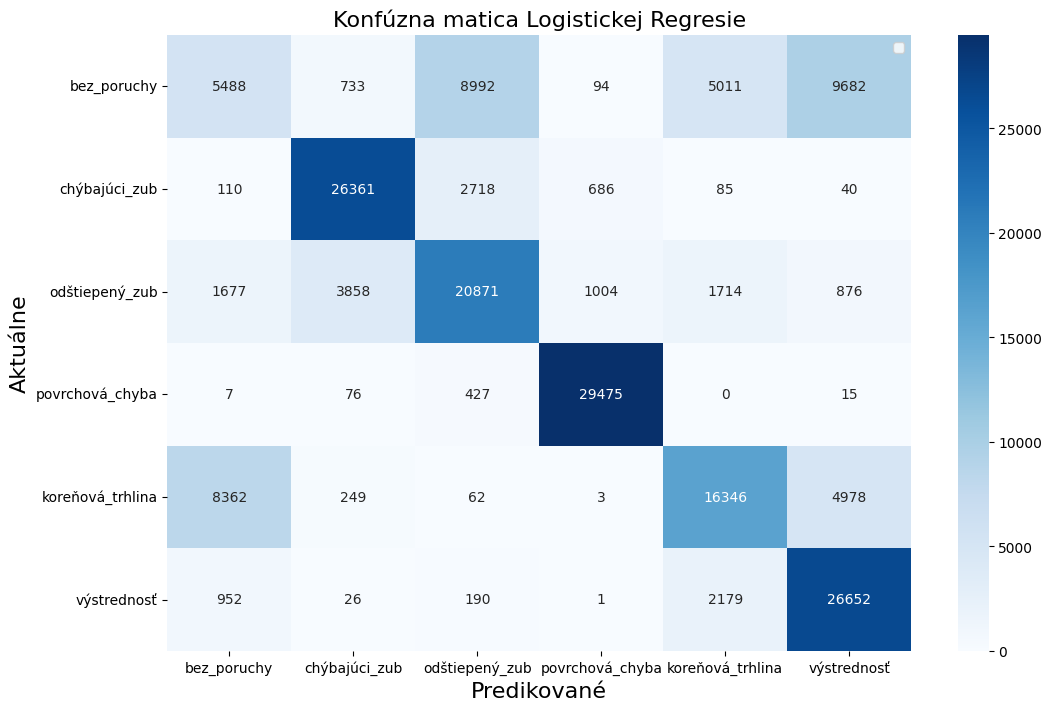

In [ ]:
y_train = X_train['state_expected']
y_test = X_test['state_expected']

# keep not standardized data in X_train_not_scaled, X_test_not_scaled, X_val_not_scaled
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()

# Drop column state_expected
X_train.drop(columns='state_expected', inplace=True)
X_test.drop(columns='state_expected', inplace=True)

X_train = X_train.drop(columns=['time_normalized'])
X_test = X_test.drop(columns=['time_normalized'])

# Solve NaN values
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
start_time1 = time()
log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
training_time = time() - start_time1
y_pred = log_reg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr)

# Save the model to a file
model_name = f'logistic_regression_{accuracy_lr:.4f}'

# Save the model
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
os.makedirs(model_directory, exist_ok=True)
joblib.dump(log_reg, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lr}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {log_reg.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
log_reg.classes_ = state_expected_keys.state.values
log_reg.classes_

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.legend([f'Presnosť: {accuracy_lr:.2f}'])
# Enlarge plot tittle font and labels
plt.title('Konfúzna matica Logistickej Regresie', fontsize=16)
plt.show()

In [ ]:
training_time

66.35181617736816

In [ ]:
X_train.shape

(720000, 54)

In [ ]:
test_times = []
train_times = []

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

None

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     30000
           1       0.95      0.95      0.95     30000
           2       0.95      0.95      0.95     30000
           3       1.00      1.00      1.00     30000
           4       0.97      0.98      0.97     30000
           5       1.00      0.98      0.99     30000

    accuracy                           0.97    180000
   macro avg       0.97      0.97      0.97    180000
weighted avg       0.97      0.97      0.97    180000



None

Model and metadata saved in models


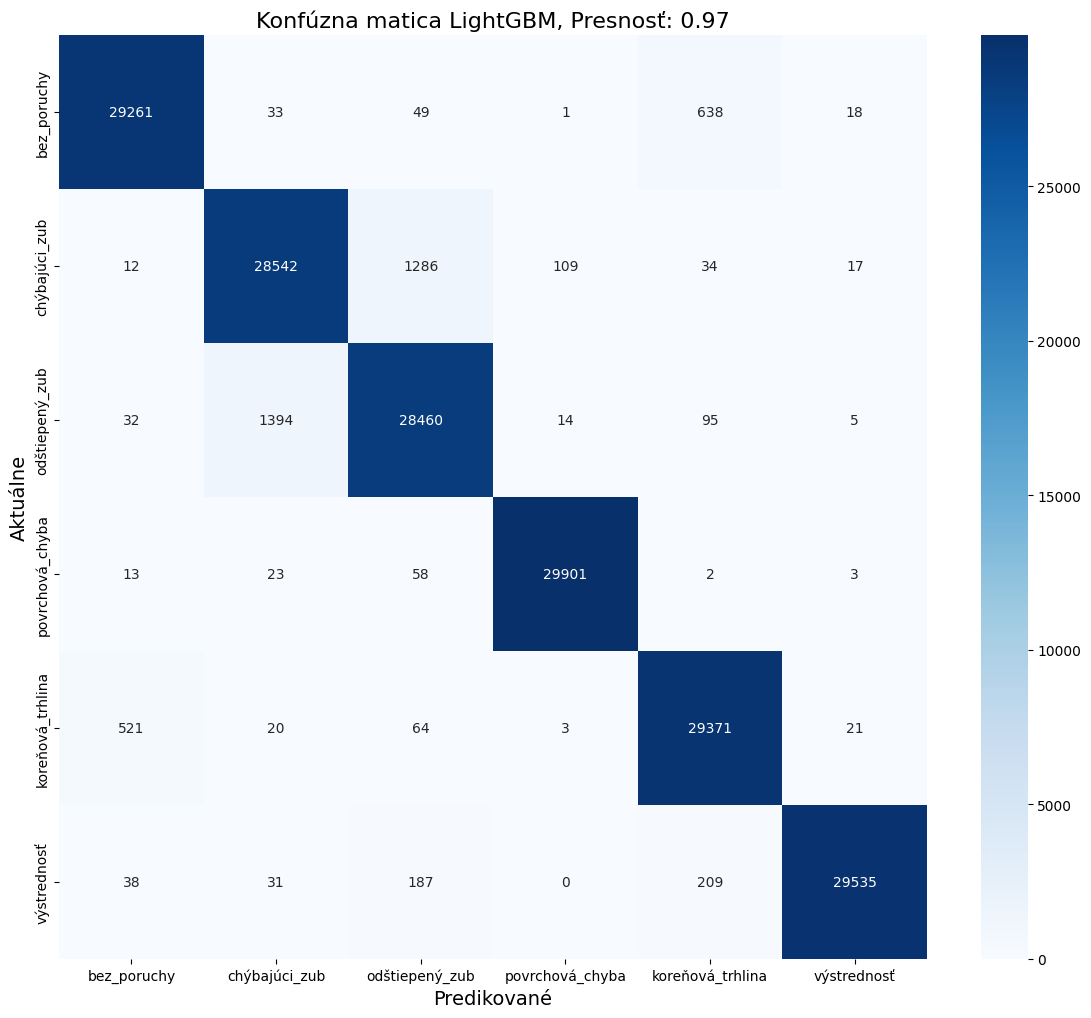

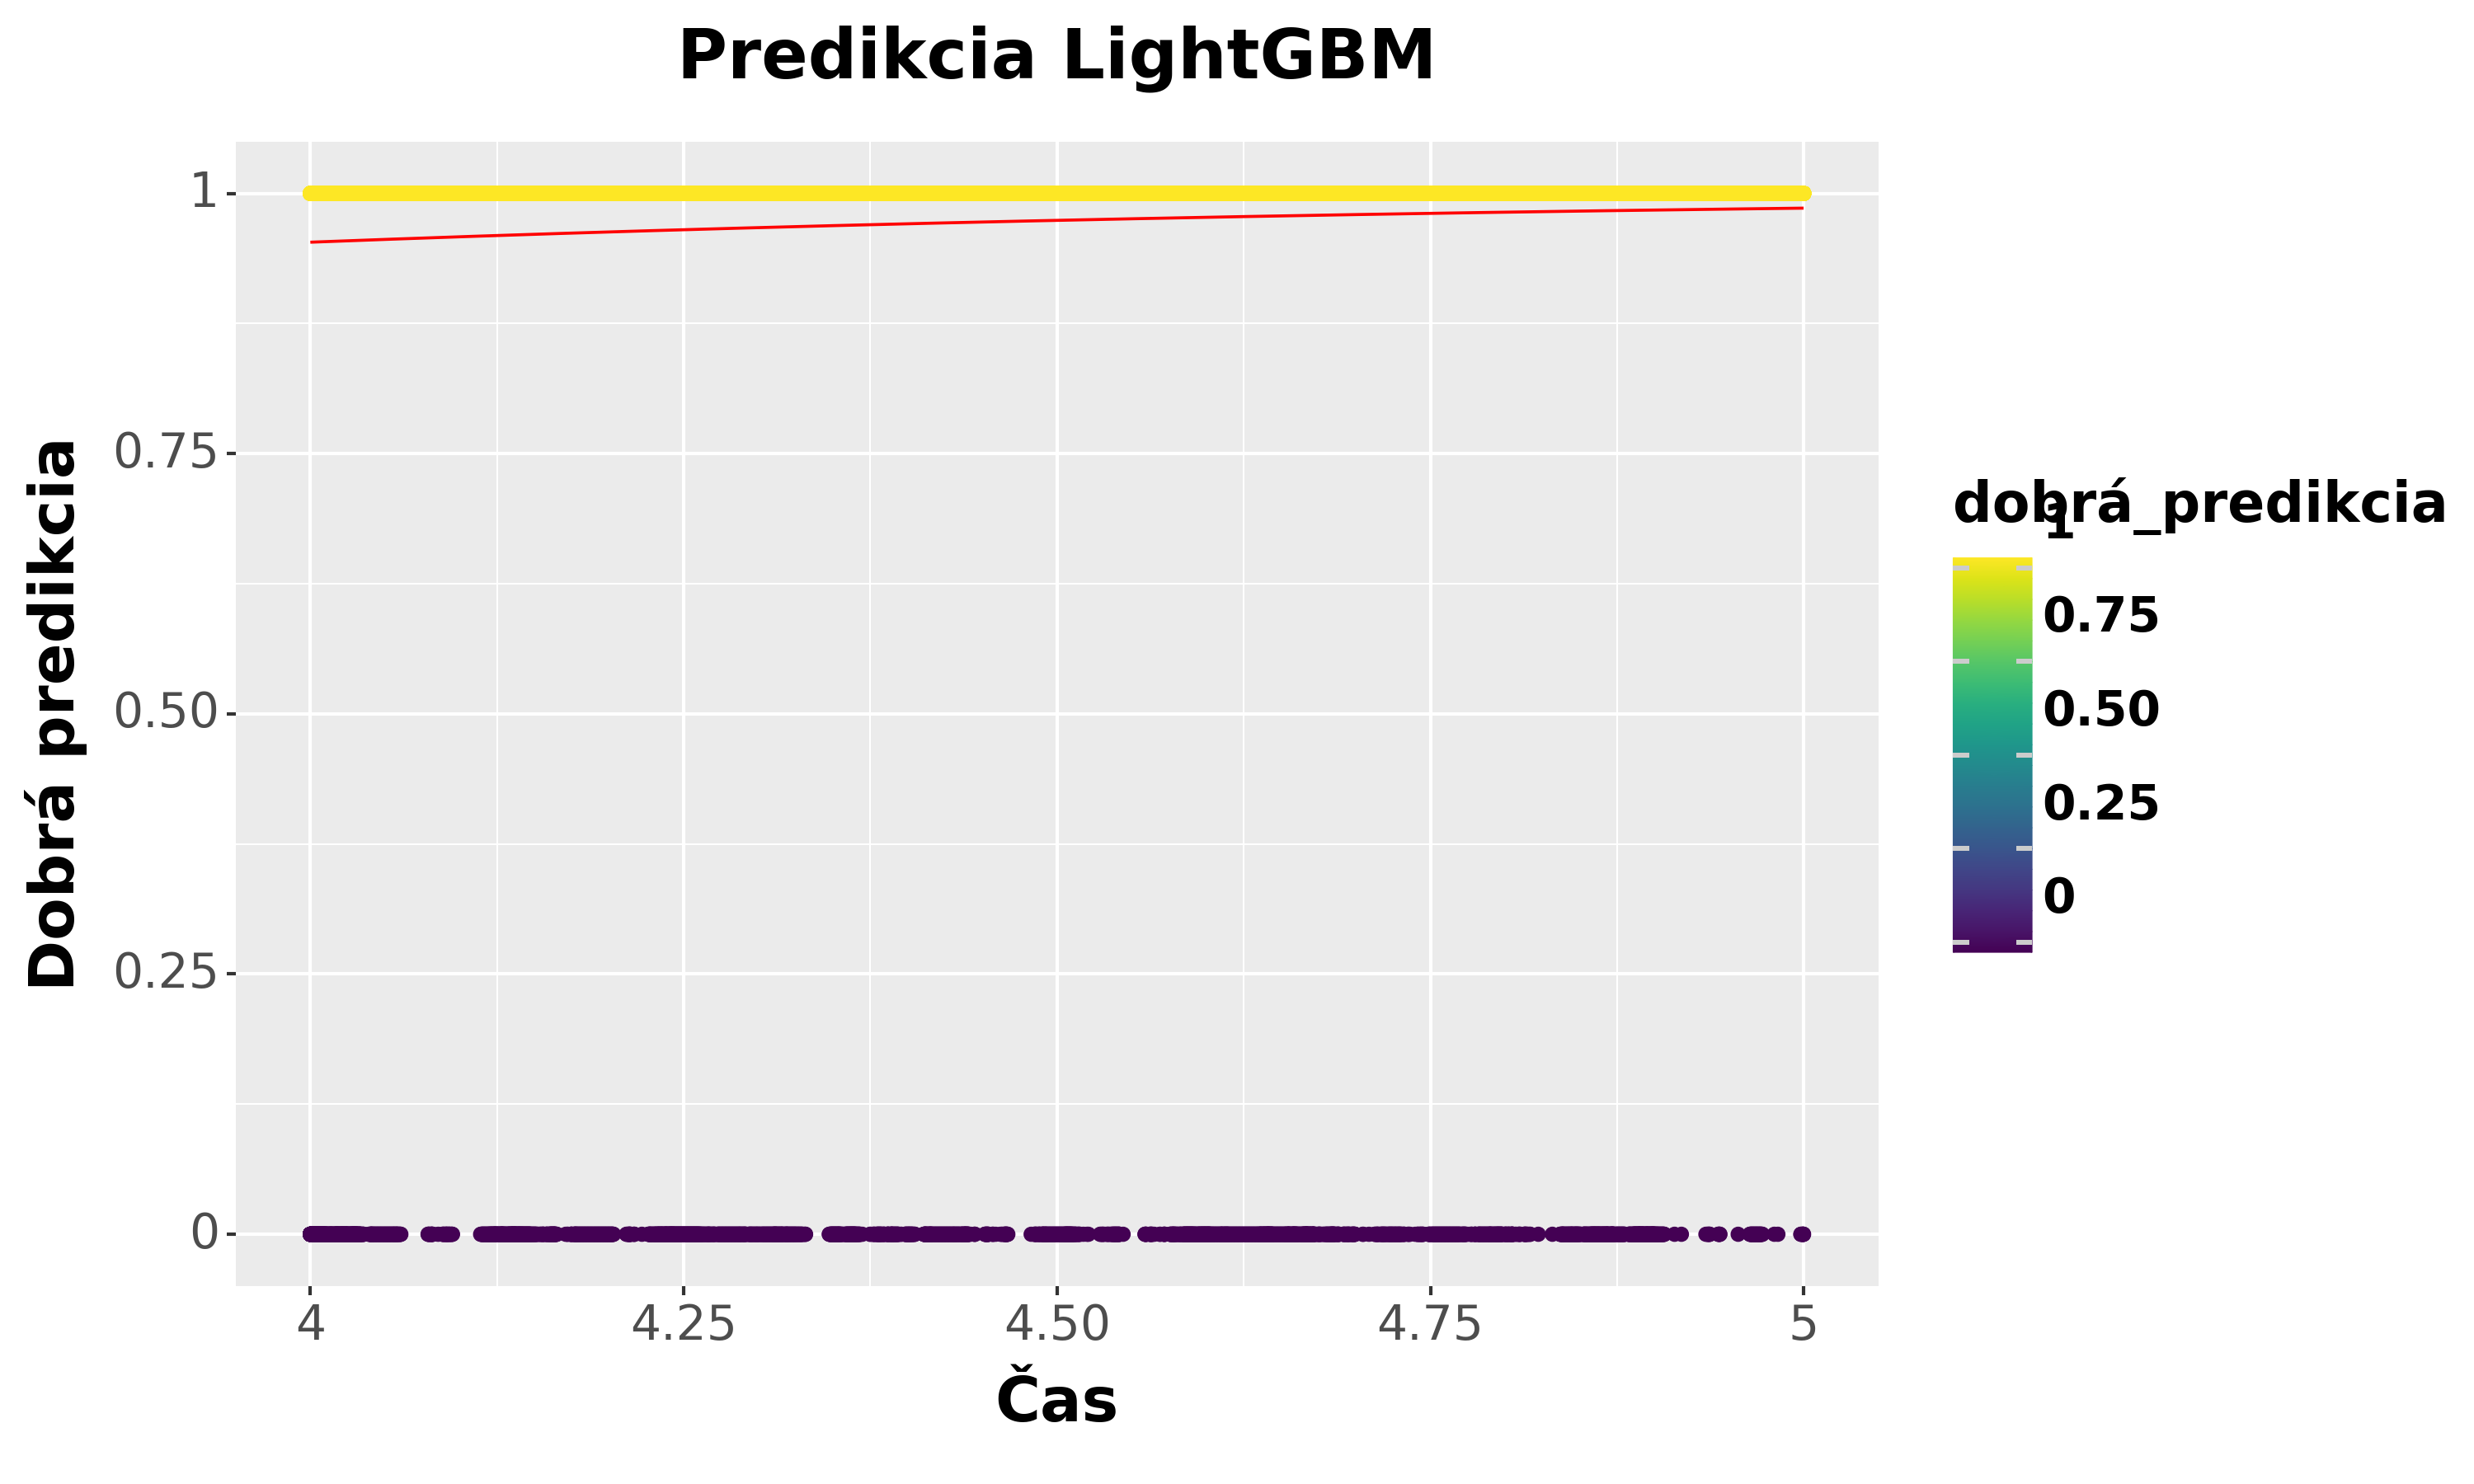

<Figure Size: (1500 x 900)>

In [ ]:
# Parameter grid for RandomizedSearch
param_grid_lgbm = {
    'num_leaves': [100],
    'min_data_in_leaf': [45],
    'max_depth': [9],
    'learning_rate': [0.2],
    'n_estimators': [200],
    'feature_fraction': [0.6],
    'bagging_fraction': [0.6],
    'bagging_freq': [4],
}

lgb_model = lgb.LGBMClassifier()

time_start2 = time()
# Grid search
best_lgb_model = GridSearchCV(lgb_model, param_grid_lgbm, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
best_lgb_model.fit(X_train, y_train)
training_time2 = time() - time_start2
best_lgb = best_lgb_model.best_estimator_
time_test2 = time()
# Predict the test set
y_pred = best_lgb.predict(X_test)
test_times.append(time() - time_test2)
train_times.append(training_time2)
# Calculate the accuracy
accuracy_lgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_lgb))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))


# Save the model to a file
model_name = f'lightgbm_{accuracy_lgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_lgb, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lgb}\n")
    f.write(f"Training Time: {training_time2} seconds\n")
    f.write(f"Hyperparameters: {best_lgb.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names in someway
predicted_names = [mapping_dict[label] for label in best_lgb.classes_]
# Show confnusion matrix as a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=14)
plt.ylabel('Aktuálne', fontsize=14)
plt.title(f'Konfúzna matica LightGBM, Presnosť: {accuracy_lgb:.2f}', fontsize=16)
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                    ggtitle('Predikcia LightGBM') +
                    labs(x='Čas', y='Dobrá predikcia', fill='Dobrá predikcia') + geom_point() +
                    theme(
                        figure_size=(10, 6),  # Width and height in inches
                        dpi=150,  # Set the resolution of the plot
                        axis_text=element_text(size=14),  # Axis tick labels
                        axis_title=element_text(size=18, weight='bold'),  # Axis titles
                        plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
                        legend_title=element_text(size=16, weight='bold'),  # Legend title
                        legend_text=element_text(size=14, weight='bold')  # Legend text
                    ))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot


In [ ]:

# Create XGB Classifier
param_grid_xgb = {
    'max_depth': [10],
    'gamma': [0.3],
    'subsample': [0.7],
    'colsample_bytree': [0.6],
    'learning_rate': [0.01],
    'n_estimators': [300],
    'min_child_weight': [1],
    'lambda': [4],
}

# Setup the model
xgb_model = xgb.XGBClassifier()

start_time3 = time()
best_xgb_model = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=4, verbose=1, scoring='accuracy', n_jobs=-1)
# Pick the best model
best_xgb_model.fit(X_train, y_train)
training_time3 = time() - start_time3
best_xgb = best_xgb_model.best_estimator_
time_test3 = time()
# Predict the test set
y_pred = best_xgb.predict(X_test)
test_times.append(time() - time_test3)
train_times.append(training_time3)

# Calculate the accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_xgb))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'xgboost_{accuracy_xgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_xgb, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_xgb}\n")
    f.write(f"Training Time: {training_time3} seconds\n")
    f.write(f"Hyperparameters: {best_xgb.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_xgb.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.title(f'Konfúzna matica XGBoost, Presnosť: {accuracy_xgb:.2f}', fontsize=16)
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                 geom_point() +
                 ggtitle('Predikcia XGB') +
                                     labs(x='Čas', y='Dobrá predikcia', fill='Dobrá predikcia') + geom_point() +
                    theme(
                        figure_size=(10, 6),  # Width and height in inches
                        dpi=150,  # Set the resolution of the plot
                        axis_text=element_text(size=14),  # Axis tick labels
                        axis_title=element_text(size=18, weight='bold'),  # Axis titles
                        plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
                        legend_title=element_text(size=16, weight='bold'),  # Legend title
                        legend_text=element_text(size=14, weight='bold')  # Legend text
                    ))


# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot


'\n# Create XGB Classifier\nparam_grid_xgb = {\n    \'max_depth\': [10],\n    \'gamma\': [0.3],\n    \'subsample\': [0.7],\n    \'colsample_bytree\': [0.6],\n    \'learning_rate\': [0.01],\n    \'n_estimators\': [300],\n    \'min_child_weight\': [1],\n    \'lambda\': [4],\n}\n\n# Setup the model\nxgb_model = xgb.XGBClassifier()\n\nstart_time3 = time()\nbest_xgb_model = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=4, verbose=1, scoring=\'accuracy\', n_jobs=-1)\n# Pick the best model\nbest_xgb_model.fit(X_train, y_train)\ntraining_time3 = time() - start_time3\nbest_xgb = best_xgb_model.best_estimator_\ntime_test3 = time()\n# Predict the test set\ny_pred = best_xgb.predict(X_test)\ntest_times.append(time() - time_test3)\ntrain_times.append(training_time3)\n\n# Calculate the accuracy\naccuracy_xgb = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_xgb))\n\n# Calculate recall, precision and f1-score\ndisplay(print(classification_report(y_test, y_pred)))\n\n# Save the 

In [ ]:
"""
# Create a KNN model for classification using the df dataset print the accuracy of the model
param_grid_knn = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['manhattan']
}

# Setup the model
knn_model = KNeighborsClassifier()

start_time4 = time()
# Pick the best model
best_knn_model = GridSearchCV(knn_model, param_grid_knn, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
best_knn_model.fit(X_train, y_train)
training_time4 = time() - start_time4

best_knn = best_knn_model.best_estimator_
time_test4 = time()
# Predict the test set
y_pred = best_knn.predict(X_test)
test_times.append(time() - time_test4)
train_times.append(training_time4)

# Calculate the accuracy
accuracy_knn = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_knn))

# Save the model to a file
model_name = f'knn_{accuracy_knn:.4f}'
model_directory = 'models'   
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_knn, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_knn}\n")
    f.write(f"Training Time: {training_time4} seconds\n")
    f.write(f"Hyperparameters: {best_knn.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_knn.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.title(f'Konfúzna matica KNN, Presnosť: {accuracy_xgb:.2f}', fontsize=16)
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                 geom_point() +
                 ggtitle('Predikcia KNN'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot
"""

'\n# Create a KNN model for classification using the df dataset print the accuracy of the model\nparam_grid_knn = {\n    \'n_neighbors\': [20],\n    \'weights\': [\'uniform\'],\n    \'metric\': [\'manhattan\']\n}\n\n# Setup the model\nknn_model = KNeighborsClassifier()\n\nstart_time4 = time()\n# Pick the best model\nbest_knn_model = GridSearchCV(knn_model, param_grid_knn, cv=4, scoring=\'accuracy\', verbose=1, n_jobs=-1)\nbest_knn_model.fit(X_train, y_train)\ntraining_time4 = time() - start_time4\n\nbest_knn = best_knn_model.best_estimator_\ntime_test4 = time()\n# Predict the test set\ny_pred = best_knn.predict(X_test)\ntest_times.append(time() - time_test4)\ntrain_times.append(training_time4)\n\n# Calculate the accuracy\naccuracy_knn = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_knn))\n\n# Save the model to a file\nmodel_name = f\'knn_{accuracy_knn:.4f}\'\nmodel_directory = \'models\'   \nmodel_path = f\'{model_directory}/{model_name}.h5\'\njoblib.dump(best_knn

In [ ]:

# Random Forest
param_grid_rf = {
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'max_depth': [6],
    'min_samples_split': [2],
    'min_samples_leaf': [4]
}

# Setup the model
rf_model = RandomForestClassifier()

start_time5 = time()
# Pick the best model
best_rf_model = GridSearchCV(rf_model, param_grid_rf, cv=4, verbose=1, n_jobs=-1)
best_rf_model.fit(X_train, y_train)
training_time5 = time() - start_time5

best_rf = best_rf_model.best_estimator_
time_test5 = time()
# Predict the test set
y_pred = best_rf.predict(X_test)
test_times.append(time() - time_test5)
train_times.append(training_time5)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_rf))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'random_forest_{accuracy_rf:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_rf, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_rf}\n")
    f.write(f"Training Time: {training_time5} seconds\n")
    f.write(f"Hyperparameters: {best_rf.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_rf.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.title(f'Konfúzna matica RandomForest, Presnosť: {accuracy_rf:.2f}', fontsize=16)
plt.show()
# Logistic Regression plot 
dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                 geom_point() +
                 ggtitle('Predikcia RF') +
                    labs(x='Čas', y='Dobrá predikcia', fill='Dobrá predikcia') + geom_point() +
                    theme(
                        figure_size=(10, 6),  # Width and height in inches
                        dpi=150,  # Set the resolution of the plot
                        axis_text=element_text(size=14),  # Axis tick labels
                        axis_title=element_text(size=18, weight='bold'),  # Axis titles
                        plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
                        legend_title=element_text(size=16, weight='bold'),  # Legend title
                        legend_text=element_text(size=14, weight='bold')  # Legend text
                    ))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot


'\n# Random Forest\nparam_grid_rf = {\n    \'n_estimators\': [200],\n    \'max_features\': [\'sqrt\'],\n    \'max_depth\': [6],\n    \'min_samples_split\': [2],\n    \'min_samples_leaf\': [4]\n}\n\n# Setup the model\nrf_model = RandomForestClassifier()\n\nstart_time5 = time()\n# Pick the best model\nbest_rf_model = GridSearchCV(rf_model, param_grid_rf, cv=4, verbose=1, n_jobs=-1)\nbest_rf_model.fit(X_train, y_train)\ntraining_time5 = time() - start_time5\n\nbest_rf = best_rf_model.best_estimator_\ntime_test5 = time()\n# Predict the test set\ny_pred = best_rf.predict(X_test)\ntest_times.append(time() - time_test5)\ntrain_times.append(training_time5)\n\n# Calculate the accuracy\naccuracy_rf = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_rf))\n\n# Calculate recall, precision and f1-score\ndisplay(print(classification_report(y_test, y_pred)))\n\n# Save the model to a file\nmodel_name = f\'random_forest_{accuracy_rf:.4f}\'\nmodel_directory = \'models\'\nmodel_path = f

In [ ]:

# Create a decision tree model for classification using the df dataset print the accuracy of the model
param_grid_dt = {
    'max_depth': [9],
    'min_samples_split': [16],
    'min_samples_leaf': [8],
    'max_features': ['sqrt'],
    'criterion': ['gini'],
    'splitter': ['best']
}

# Setup the model
dt_model = DecisionTreeClassifier()

start_time6 = time()
# Pick the best model
best_dt_model = GridSearchCV(dt_model, param_grid_dt, cv=4, verbose=1, n_jobs=-1)
best_dt_model.fit(X_train, y_train)
training_time6 = time() - start_time6

best_dt = best_dt_model.best_estimator_
time_test6 = time()
# Predict the test set
y_pred = best_dt.predict(X_test)
test_times.append(time() - time_test6)
train_times.append(training_time6)

# Calculate the accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_dt))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'decision_tree_{accuracy_dt:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_dt, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_dt}\n")
    f.write(f"Training Time: {training_time6} seconds\n")
    f.write(f"Hyperparameters: {best_dt.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_dt_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.title(f'Konfúzna matica DecisionTree, Presnosť: {accuracy_dt:.2f}', fontsize=16)
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                 geom_point()  +
                 ggtitle('Predikcia DT') +
                    labs(x='Čas', y='Dobrá predikcia', fill='Dobrá predikcia') + geom_point() +
                    theme(
                        figure_size=(10, 6),  # Width and height in inches
                        dpi=150,  # Set the resolution of the plot
                        axis_text=element_text(size=14),  # Axis tick labels
                        axis_title=element_text(size=18, weight='bold'),  # Axis titles
                        plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
                        legend_title=element_text(size=16, weight='bold'),  # Legend title
                        legend_text=element_text(size=14, weight='bold')  # Legend text
                    ))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot


'\n# Create a decision tree model for classification using the df dataset print the accuracy of the model\nparam_grid_dt = {\n    \'max_depth\': [9],\n    \'min_samples_split\': [16],\n    \'min_samples_leaf\': [8],\n    \'max_features\': [\'sqrt\'],\n    \'criterion\': [\'gini\'],\n    \'splitter\': [\'best\']\n}\n\n# Setup the model\ndt_model = DecisionTreeClassifier()\n\nstart_time6 = time()\n# Pick the best model\nbest_dt_model = GridSearchCV(dt_model, param_grid_dt, cv=4, verbose=1, n_jobs=-1)\nbest_dt_model.fit(X_train, y_train)\ntraining_time6 = time() - start_time6\n\nbest_dt = best_dt_model.best_estimator_\ntime_test6 = time()\n# Predict the test set\ny_pred = best_dt.predict(X_test)\ntest_times.append(time() - time_test6)\ntrain_times.append(training_time6)\n\n# Calculate the accuracy\naccuracy_dt = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_dt))\n\n# Calculate recall, precision and f1-score\ndisplay(print(classification_report(y_test, y_pred)))\n\n# 

In [ ]:
"""
# Create the SVM model with specific parameters
random_search_svm = SVC(
        C=5, 
        gamma='scale', 
        kernel='rbf', 
        class_weight='balanced', 
        decision_function_shape='ovr'
    )

start_time7 = time()
# Pick the best model
best_svm_model = random_search_svm.fit(X_train, y_train)
training_time7 = time() - start_time7

best_svm = best_svm_model
time_test7 = time()
# Predict the test set
y_pred = best_svm.predict(X_test)
test_times.append(time() - time_test7)
train_times.append(training_time7)

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_svm))

# Print the validation accuracy
display(print(f'Validation Accuracy for SVM: {accuracy_svm}'))

# Save the model to a file
model_name = f'svm_{accuracy_svm:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_svm, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_svm}\n")
    f.write(f"Training Time: {training_time7} seconds\n")
    f.write(f"Hyperparameters: {best_svm.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_svm.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.title(f'Konfúzna matica SVM, Presnosť: {accuracy_svm:.2f}', fontsize=16)
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                 geom_point() +
                 ggtitle('Predikcia SVM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot
"""

'\n# Create the SVM model with specific parameters\nrandom_search_svm = SVC(\n        C=5, \n        gamma=\'scale\', \n        kernel=\'rbf\', \n        class_weight=\'balanced\', \n        decision_function_shape=\'ovr\'\n    )\n\nstart_time7 = time()\n# Pick the best model\nbest_svm_model = random_search_svm.fit(X_train, y_train)\ntraining_time7 = time() - start_time7\n\nbest_svm = best_svm_model\ntime_test7 = time()\n# Predict the test set\ny_pred = best_svm.predict(X_test)\ntest_times.append(time() - time_test7)\ntrain_times.append(training_time7)\n\n# Calculate the accuracy\naccuracy_svm = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_svm))\n\n# Print the validation accuracy\ndisplay(print(f\'Validation Accuracy for SVM: {accuracy_svm}\'))\n\n# Save the model to a file\nmodel_name = f\'svm_{accuracy_svm:.4f}\'\nmodel_directory = \'models\'\nmodel_path = f\'{model_directory}/{model_name}.h5\'\njoblib.dump(best_svm, model_path)\n\n# Save the metadata\nmetadata

In [ ]:

# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model
param_distributions_mlp = {
    #'hidden_layer_sizes': [(100,), (250,50)],
    'hidden_layer_sizes': [(100)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.15],
    'learning_rate': ['adaptive'],
    'batch_size': [32],
    'max_iter': [300],
    'shuffle': [False],
    'early_stopping': [True],
}

# Setup the model
mlp_model = MLPClassifier()

start_time8 = time()
grid_search_mlp = GridSearchCV(mlp_model, param_distributions_mlp, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
# Pick the best model
best_mlp_model = grid_search_mlp.fit(X_train, y_train)
training_time8 = time() - start_time8

best_mlp = best_mlp_model.best_estimator_
time_test8 = time()
# Predict the test set
y_pred = best_mlp.predict(X_test)
test_times.append(time() - time_test8)
train_times.append(training_time8)

# Calculate the accuracy
accuracy_mlp = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_mlp))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'mlp_{accuracy_mlp:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_mlp, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_mlp}\n")
    f.write(f"Training Time: {training_time8} seconds\n")
    f.write(f"Hyperparameters: {best_mlp.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")


'\n# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model\nparam_distributions_mlp = {\n    #\'hidden_layer_sizes\': [(100,), (250,50)],\n    \'hidden_layer_sizes\': [(100)],\n    \'activation\': [\'relu\'],\n    \'solver\': [\'adam\'],\n    \'alpha\': [0.15],\n    \'learning_rate\': [\'adaptive\'],\n    \'batch_size\': [32],\n    \'max_iter\': [300],\n    \'shuffle\': [False],\n    \'early_stopping\': [True],\n}\n\n# Setup the model\nmlp_model = MLPClassifier()\n\nstart_time8 = time()\ngrid_search_mlp = GridSearchCV(mlp_model, param_distributions_mlp, cv=4, scoring=\'accuracy\', verbose=1, n_jobs=-1)\n# Pick the best model\nbest_mlp_model = grid_search_mlp.fit(X_train, y_train)\ntraining_time8 = time() - start_time8\n\nbest_mlp = best_mlp_model.best_estimator_\ntime_test8 = time()\n# Predict the test set\ny_pred = best_mlp.predict(X_test)\ntest_times.append(time() - time_test8)\ntrain_times.append(training_time8)\n\n# Calculate t

In [ ]:

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_mlp.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované', fontsize=16)
plt.ylabel('Aktuálne', fontsize=16)
plt.title(f'Konfúzna matica MLP, Presnosť: {accuracy_mlp:.2f}', fontsize=16)
plt.show()

dfer = y_test.reset_index(drop=True).to_frame()
dfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome
X = dfer[['čas']].values  # Features need to be 2D for scikit-learn
y = dfer['dobrá_predikcia'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['čas'].min(), dfer['čas'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='čas', y='dobrá_predikcia', color='dobrá_predikcia')) +
                 geom_point() +
                 ggtitle('Predikcia MLP') +
                                     labs(x='Čas', y='Dobrá predikcia', fill='Dobrá predikcia') + geom_point() +
                    theme(
                        figure_size=(10, 7),  # Width and height in inches
                        dpi=150,  # Set the resolution of the plot
                        axis_text=element_text(size=14),  # Axis tick labels
                        axis_title=element_text(size=18, weight='bold'),  # Axis titles
                        plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
                        legend_title=element_text(size=16, weight='bold'),  # Legend title
                        legend_text=element_text(size=14, weight='bold')  # Legend text
                    ))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'čas': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='čas', y='probability'), color='red'))

logistic_plot


"\n# Calculate the confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Trasnform classes from numerical to names using state_expected_keys\npredicted_names = [mapping_dict[label] for label in best_mlp.classes_]\n\n# Show confnusion matrix as a heatmap\nplt.figure(figsize=(12, 12))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)\nplt.xlabel('Predikované', fontsize=16)\nplt.ylabel('Aktuálne', fontsize=16)\nplt.title(f'Konfúzna matica MLP, Presnosť: {accuracy_mlp:.2f}', fontsize=16)\nplt.show()\n\ndfer = y_test.reset_index(drop=True).to_frame()\ndfer['čas'] = X_test_not_scaled.time_normalized.reset_index(drop=True)\ndfer['state'] = y_pred\ndfer['yval'] = y_test.reset_index(drop=True)\ndfer['range'] = dfer.index\ndfer['dobrá_predikcia'] = (dfer.state == dfer.yval).astype(int)\n\n# Assuming 'čas' is your feature and 'dobrá_predikcia' is the binary outcome\nX = dfer[['čas']].values  # Features need to be 2D for scikit-lea

Best model: lightGBM, Validation Accuracy: 0.9726111111111111


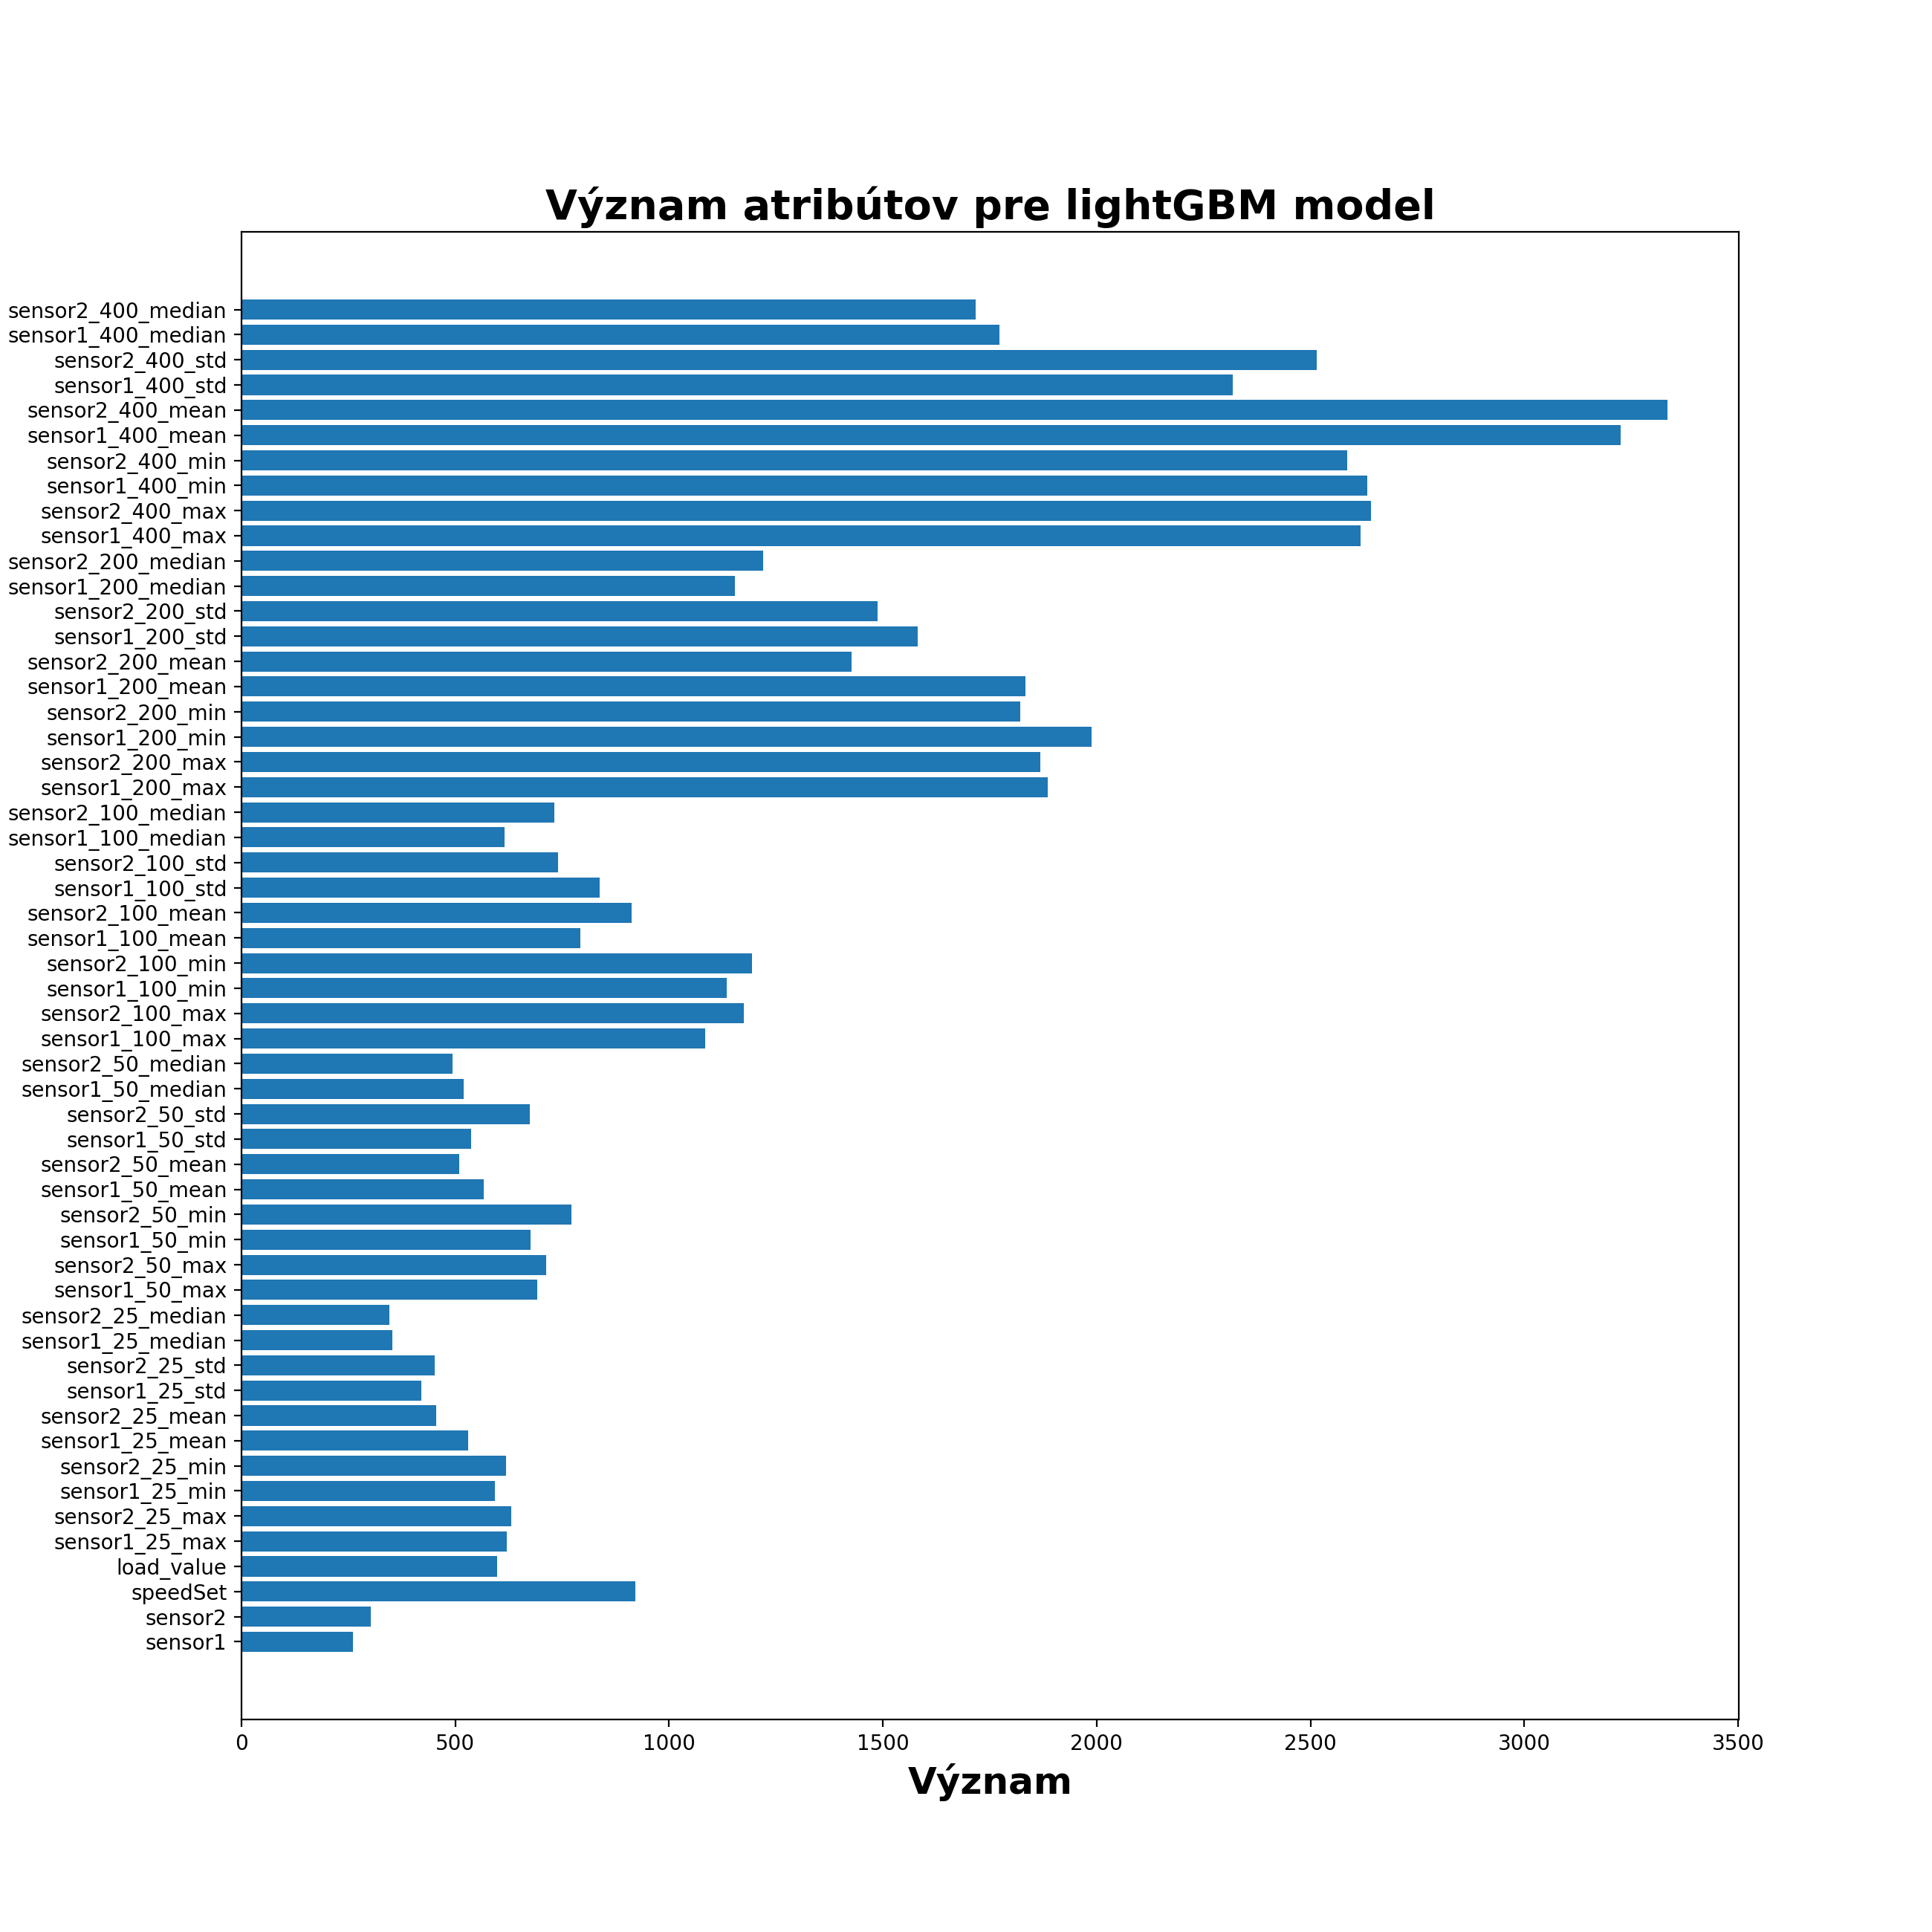

<Figure size 640x480 with 0 Axes>

In [ ]:
# Find the best models trained so far and print their names and validation accuracies and do feature importance the model
# with the highest validation accuracy

models = {
   'lightGBM': accuracy_lgb,
    #'xgboost': accuracy_xgb,
    #'knn': accuracy_knn,
    #'random_forest': accuracy_rf,
    #'decision_tree': accuracy_dt,
    #'svm': accuracy_svm,
    #'mlp': accuracy_mlp,
}

# Find the best model
best_model_name = max(models, key=models.get)
best_model_accuracy = models[best_model_name]

print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')

# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Feature importance
# If knn then we do it differently
if best_model_name == 'knn':
    # Perform permutation importance
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()
# And if mlp then we do it differently
elif best_model_name == 'mlp':
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.figure(figsize=(13, 13))
    plt.xlabel('Význam', fontsize=18, weight='bold')
    plt.ylabel('Atribúty', fontsize=18, weight='bold')
    plt.title(f'Význam atribútov pre {best_model_name} Model', fontsize=20, weight='bold')
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
    plt.show()
elif best_model_name == 'svm':
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.figure(figsize=(13, 13))
    plt.xlabel('Význam', fontsize=18, weight='bold')
    plt.ylabel('Atribúty', fontsize=18, weight='bold')
    plt.title(f'Význam atribútov pre {best_model_name} Model', fontsize=20, weight='bold')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()

else:
    feature_imp = best_model.feature_importances_
    X_test_not_scaled_droped = X_test_not_scaled.drop(columns=['time_normalized', 'state_expected'])

    # Plot feature importance
    plt.figure(figsize=(13, 13))
    plt.barh(X_test_not_scaled_droped.columns, feature_imp)

    plt.xlabel('Význam', fontsize=18, weight='bold')
    plt.ylabel('Atribúty', fontsize=18, weight='bold')
    plt.title(f'Význam atribútov pre {best_model_name} model', fontsize=20, weight='bold')
    plt.show()
    
plt.savefig(f'plots/feature_importance_{best_model_name}_{best_model_accuracy:.4f}.png')

Best model: lightgbm, Validation Accuracy: 0.9728
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGB

None

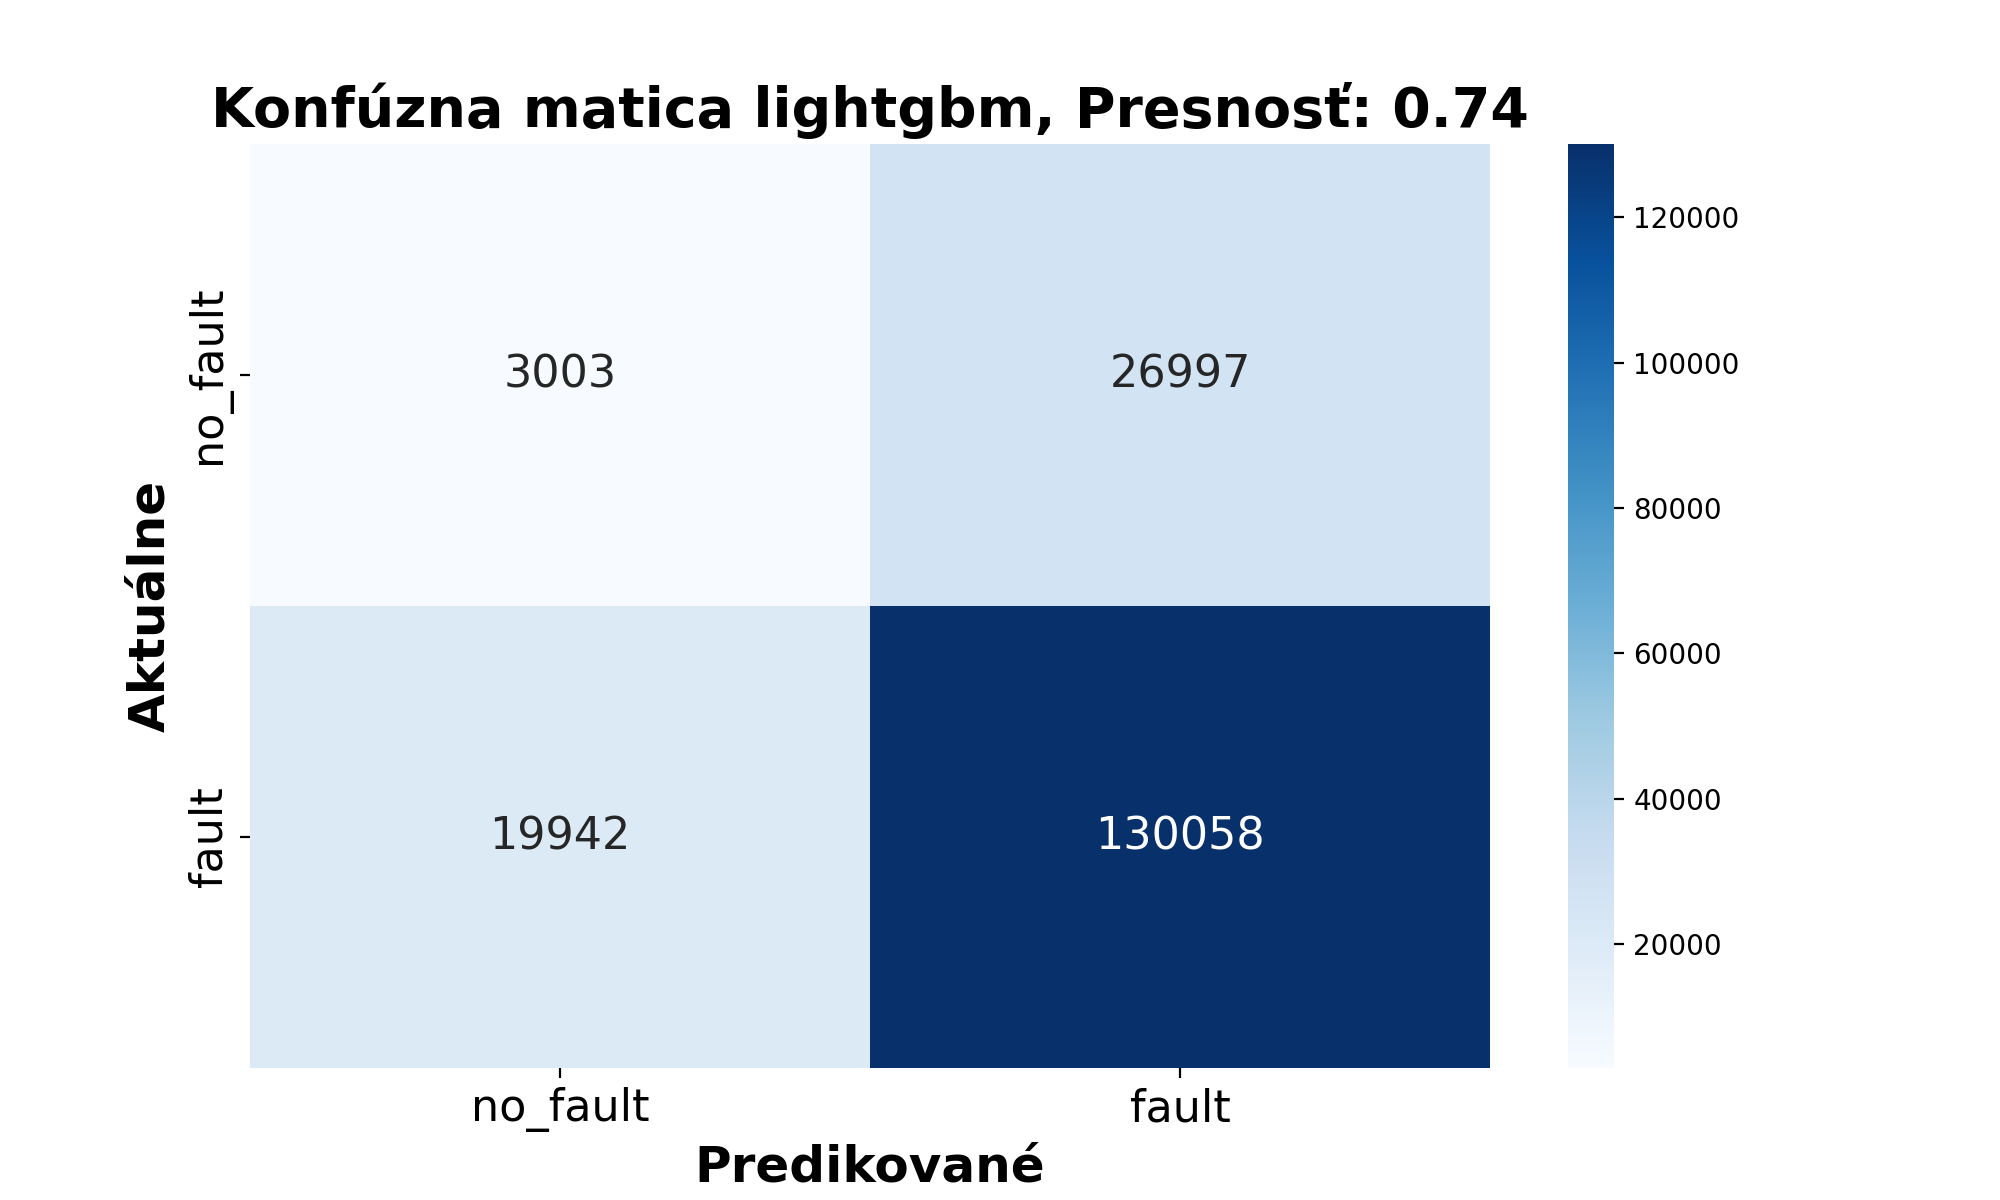

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<Figure size 640x480 with 0 Axes>

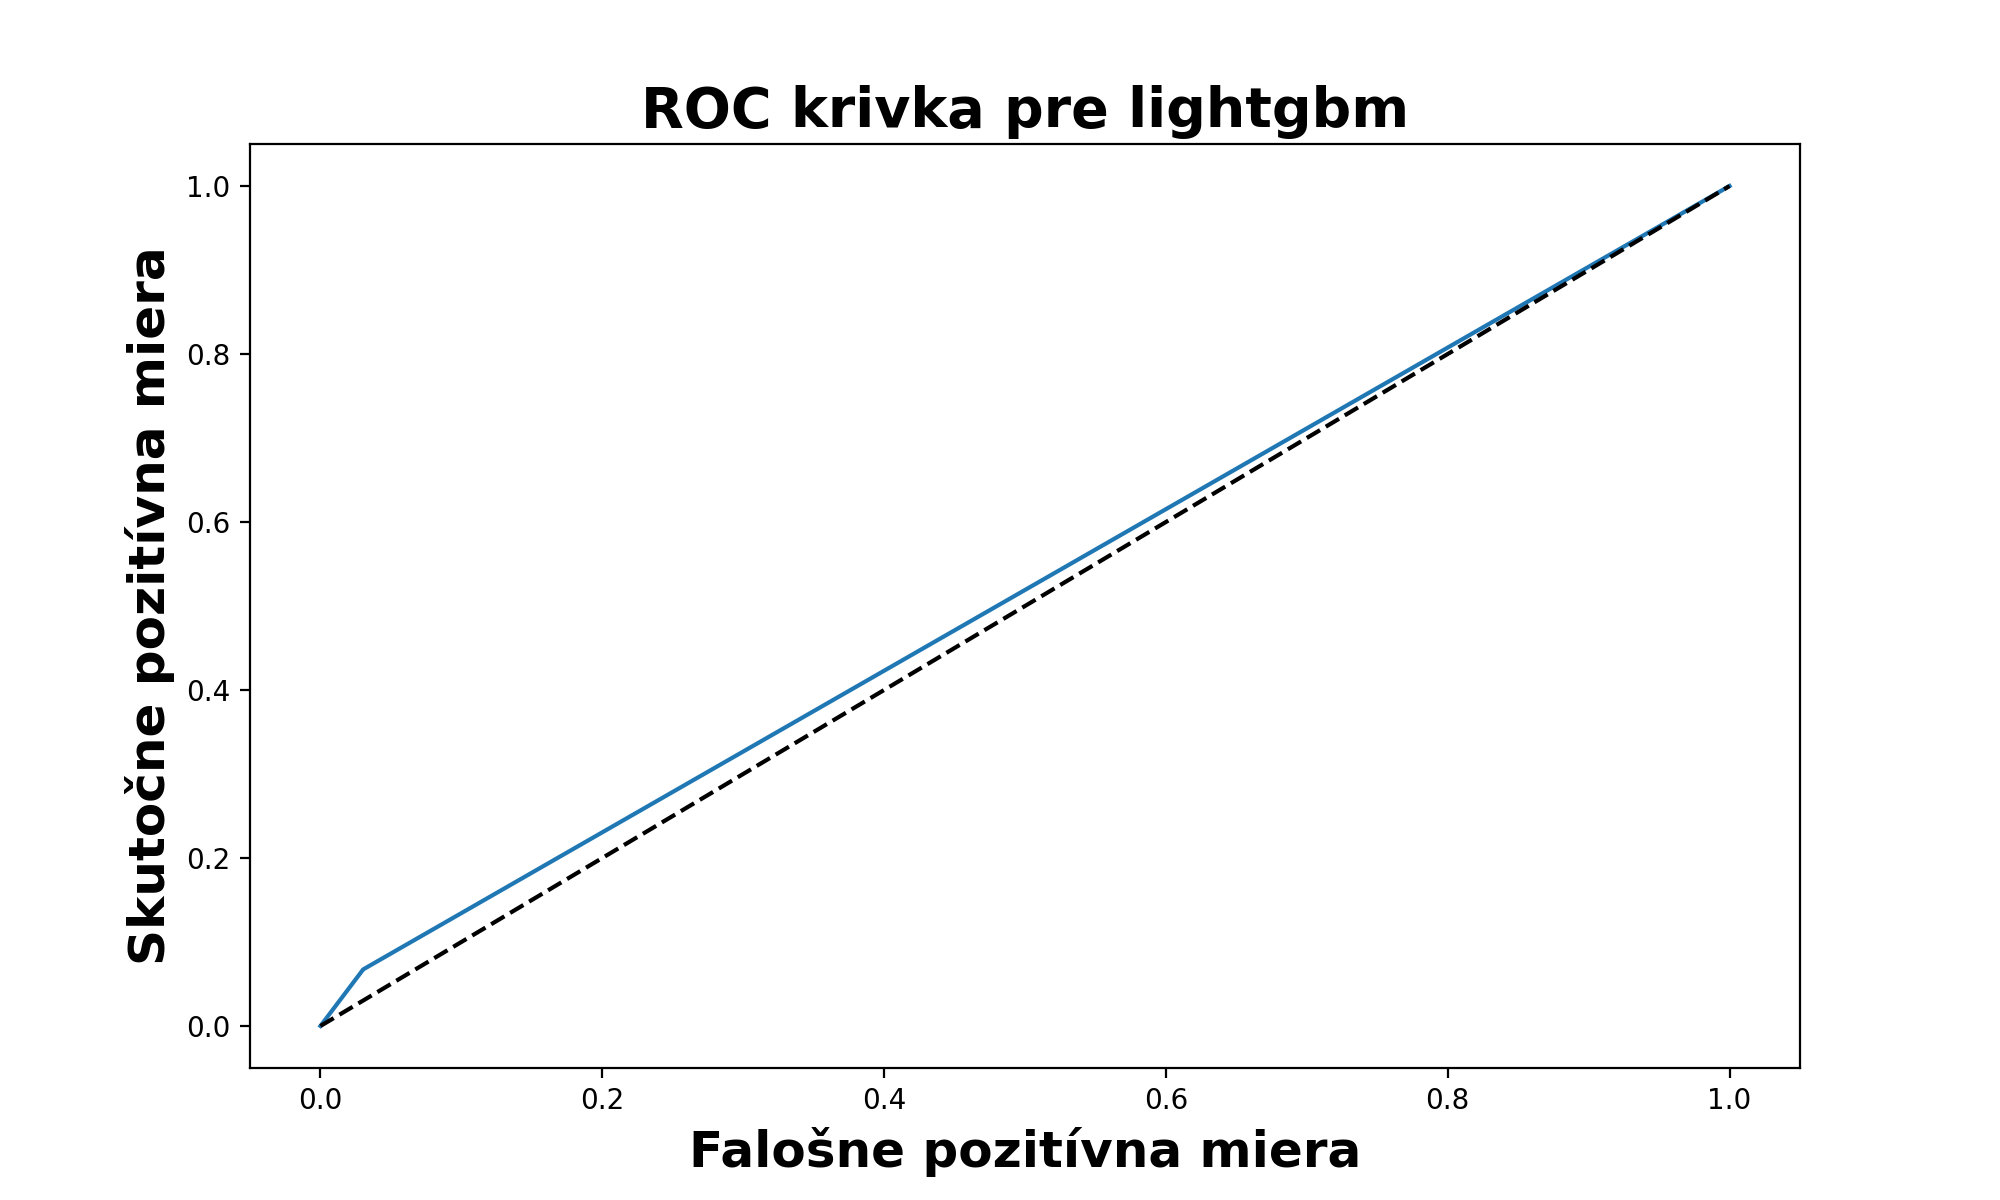

<Figure size 640x480 with 0 Axes>

In [ ]:
# Transform y_test arrays values where the number does not equals 0 to 1
y_tests = np.where(y_test != 0, 1, 0)
unique, counts = np.unique(y_tests, return_counts=True)

# Directory containing the models
model_directory = 'models'
models = os.listdir(model_directory)
model_accuracies = {}

for model in models:
    if model.endswith('.h5'):
        # Split the filename to isolate the parts
        parts = model.rsplit('_', 1)  # This splits only at the last underscore
        model_name = '_'.join(parts[:-1])  # Rejoin all but the last part for the full model name
        accuracy_part = parts[-1].replace('.h5', '')  # The last part, without '.h5'
        
        try:
            model_accuracy = float(accuracy_part)  # Convert the accuracy part to float
            model_accuracies[model_name] = model_accuracy  # Store using model name
        except ValueError:
            print(f"Could not convert {accuracy_part} to float for model {model}")

# Find the model with the highest accuracy
if model_accuracies:
    best_model_name, best_model_accuracy = max(model_accuracies.items(), key=lambda item: item[1])
    print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')
else:
    print("No valid model accuracies found.")

# Predict with the best model and evaluate, plot the confusion matrix and the ROC curve
# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Refit model on the full training data
best_model.fit(X_train, y_train)

# Predict the test set
y_preds = best_model.predict(X_test)
y_preds = np.where(y_preds != 0, 1, 0)

# Calculate the accuracy
accuracy = accuracy_score(y_tests, y_preds)
display(print(f'Accuracy: {accuracy:.4f}'))

# Calculate the confusion matrix
cm = confusion_matrix(y_tests, y_preds)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fault', 'fault'], yticklabels=['no_fault', 'fault'], annot_kws={"size": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('Predikované', fontsize=18, weight='bold')
plt.ylabel('Aktuálne', fontsize=18, weight='bold')
plt.title(f'Konfúzna matica {best_model_name}, Presnosť: {accuracy:.2f}',  fontsize=20, weight='bold')
plt.show()
plt.savefig(f'plots/confusion_matrix_{best_model_name}_{best_model_accuracy:.4f}.png')
# Calculate the ROC curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_tests, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falošne pozitívna miera', fontsize=18, weight='bold')
plt.ylabel('Skutočne pozitívna miera', fontsize=18, weight='bold')
plt.title(f'ROC krivka pre {best_model_name}', fontsize=20, weight='bold')
plt.show()
plt.savefig(f'plots/roc_curve_{best_model_name}_{best_model_accuracy:.4f}.png')


In [ ]:
# Print the classification report
print(classification_report(y_tests, y_preds))

              precision    recall  f1-score   support

           0       0.13      0.10      0.11     30000
           1       0.83      0.87      0.85    150000

    accuracy                           0.74    180000
   macro avg       0.48      0.48      0.48    180000
weighted avg       0.71      0.74      0.72    180000



In [ ]:
# Print test times
print(f'Testing times: {test_times}')

Testing times: [5.3317482471466064]


In [ ]:
# Print training times
print(f'Training times: {train_times}')

Training times: [153.4500253200531]
